# 第七课 图深度学习应用（二）

本次课程我们继续了解图深度学习的应用。具体地，我们以**计算机视觉**中多标签图像分类为例，展示图神经网络在该任务的利用。在多标签图像分类中，给定一张图片，我们需要预测该图片的多个标签，比如图片中的多个物体。一个常见的应用于多标签图像分类任务的模型是[ML-GCN](https://arxiv.org/abs/1904.03582)。ML-GCN分为两个部分：（1）提取图像特征的CNN和（2）提取目标标签的依赖关系信息的GCN。接下来，我们将对该模型进行细致地讲解。

Multi-Label Image Recognition with Graph Convolutional Networks. CVPR 2019.

## 1. 多标签图像分类数据集 - VOC 2007

首先让我们来看看本次任务需要用到的数据集。VOC 2007是多标签图像分类任务的常用标准数据集。它包含了9,963张图片，每张图片当中包含了一些物体，这些物体一共有20个不同的类别：
* 人: 人
* 动物: 鸟, 猫, 牛, 狗, 马, 羊
* 交通工具: 飞机, 自行车, 船, 公交车, 汽车, 摩托车, 火车
* 室内物品: 瓶子, 椅子, 餐桌, 盆栽, 沙发, 电视/显示器

In [1]:
# 首先导入需要用到的工具包
import os
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
from voc import Voc2007Classification
from util import *

In [2]:
# 加载数据集
train_dataset = Voc2007Classification('data/voc', 'trainval', inp_name='data/voc/voc_glove_word2vec.pkl')
test_dataset = Voc2007Classification('data/voc', 'test', inp_name='data/voc/voc_glove_word2vec.pkl')

[dataset] read data/voc/files/VOC2007/classification_trainval.csv
[dataset] VOC 2007 classification set=trainval number of classes=20  number of images=5011
[dataset] read data/voc/files/VOC2007/classification_test.csv
[dataset] VOC 2007 classification set=test number of classes=20  number of images=4952


值得注意的是：
* 我们的数据文件放在`data/voc`文件夹下；
* `Voc2007Classification`类接受了一个`inp_name`的参数。这个参数是Glove词嵌入的文件(每个词嵌入是一个300维的向量)。在构建标签类别的关系图时，ML-GCN将每个标签类别作为节点，类别对应的词嵌入则是节点特征。

In [3]:
sample0 = train_dataset[0] # 取出第一个数据样本，sample0包含了数据的特征和标签

In [4]:
sample0[1] # 数据标签

tensor([-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])

数据特征是一个三元组，它包含：
1. 图片本身
1. 图片文件索引
1. 图片的标签

In [5]:
feat = sample0[0] # （数据特征）
print('length:', len(feat))

length: 3


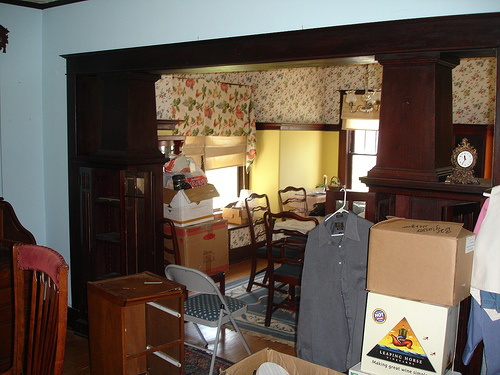

In [6]:
feat[0] # 图片本身

In [7]:
feat[1] # 图片文件的索引

'000005'

In [8]:
feat[2], feat[2].shape # 标签的特征（词嵌入）

(array([[ 0.16995 ,  0.081066, -0.089792, ...,  0.03031 , -0.13515 ,
          0.10285 ],
        [ 0.19735 , -0.3669  , -0.12089 , ...,  0.36519 ,  0.33658 ,
         -0.33163 ],
        [ 0.31526 ,  0.65435 , -0.20719 , ..., -0.19305 ,  0.19785 ,
         -0.31646 ],
        ...,
        [-0.12367 ,  0.16739 ,  0.1525  , ...,  0.54876 ,  0.19386 ,
          0.73832 ],
        [-0.037208, -0.066545,  0.15115 , ..., -0.060458,  0.44498 ,
          0.10385 ],
        [ 0.069958,  0.53197 ,  0.20131 , ...,  0.49817 , -0.011646,
          0.12519 ]], dtype=float32),
 (20, 300))

接下来我们来看看类别标签之间的关联矩阵是如何构建的。

首先我们会根据类别标签的共现关系构建出关联矩阵$\boldsymbol{P}$（存储在`data/voc/voc_adj.pkl`）。得到关联矩阵$\boldsymbol{P}$后，对该矩阵进行二值化处理：
$$\boldsymbol{A}_{i j}=\left\{\begin{array}{ll}0, & \text { if } \boldsymbol{P}_{i j}<\tau \\ 1, & \text { if } \boldsymbol{P}_{i j} \geq \tau\end{array}\right.$$
ML-GCN还会对这个二值化后的矩阵进一步处理，加强自身节点的权重的影响。
$$\boldsymbol{A}_{i j}^{\prime}=\left\{\begin{array}{ll}p / \sum_{j=1 \atop i \neq j}^{C} \boldsymbol{A}_{i j}, & \text { if } i \neq j \\ 1, & \text { if } i=j\end{array}\right.$$


In [9]:
def gen_A(num_classes, tau, adj_file):
    import pickle
    result = pickle.load(open(adj_file, 'rb')) # 加载数据文件
    _adj = result['adj']  # 共现的矩阵
    _nums = result['nums']
    _nums = _nums[:, np.newaxis]
    _adj = _adj / _nums  # P_{ij}
    _adj[_adj < tau] = 0 
    _adj[_adj >= tau] = 1 # 二值化处理
    _adj = _adj * 0.25 / (_adj.sum(0, keepdims=True) + 1e-6) 
    _adj = _adj + np.identity(num_classes, np.int) # 加强自身节点的权重的影响
    return _adj

In [10]:
num_classes = 20
class_adj = gen_A(num_classes, tau=0.4, adj_file='data/voc/voc_adj.pkl') 
class_adj.shape

(20, 20)

In [11]:
class_adj[0:2] # 取出前两行

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.04999999,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

## 2. ML-GCN模型结构

ML-GCN模型分为两个部分：
* 图像特征的提取。我们运用ResNet101。输入图像I为`448*448`大小，输出为`2048*14*14`大小的特征图，然后进行全局池化并得到一个2048的向量。
* 目标标签的依赖关系信息的提取。每个目标标签对应图中的一个节点，节点的特征是300维的向量。这里我们采用GCN在该图上提取特征，会得到20x2048维的矩阵。其中每一个2048维的向量都对应了一个类别的分类器。

![](ml-gcn.png)

首先我们来看模型的总体结构。

In [12]:
class GCNResnet(nn.Module):
    def __init__(self, model, num_classes, in_channel=300, class_adj=None):
        """
        参数说明：
        model: 提取图像信息的模型（如ResNet）
        num_classes: 类别数量
        in_channel: GCN的输入神经元的数量，也就是词嵌入的维度
        class_adj: 类别的关联矩阵
        """
        super(GCNResnet, self).__init__()
        self.features = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
        )
        self.num_classes = num_classes
        self.pooling = nn.MaxPool2d(14, 14)

        self.gc1 = GraphConvolution(in_channel, 1024, with_bias=False)
        self.gc2 = GraphConvolution(1024, 2048, with_bias=False)
        self.relu = nn.LeakyReLU(0.2)

        self.A = Parameter(torch.from_numpy(class_adj).float()) # 这里虽然是用Parameter表示self.A，但实际上我们并不会更新它
        
    def forward(self, img_feature, class_feature):
        """前向传播过程。
        
        参数说明
        ----
        img_feature: 输入图片
        class_feature: 类别的特征（word embedding）
        """
        img_feature = self.features(img_feature)  # feature: [B, 2048, 14, 14] (B是batch size)
        img_feature = self.pooling(img_feature)  # feature: [B, 2048, 1, 1]
        img_feature = img_feature.view(img_feature.size(0), -1) # feature: [B, 2048] 


        class_feature = class_feature[0] # 20x300的矩阵，inp[0], inp[1], inp[2]... 都是一样的元素
        adj = normalize_adj(self.A).detach() # adj: [20, 20]
        x = self.gc1(class_feature, adj) # x: [20, 1024]
        x = self.relu(x)    
        x = self.gc2(x, adj) # x: [20, 2048]

        x = x.transpose(0, 1) # x: [2048, 20]
        x = torch.matmul(img_feature, x) # x: [B, 20]
        return x

    def get_config_optim(self, lr, lrp):
        """对不同的参数设置不同的学习率"""
        return [
                {'params': self.features.parameters(), 'lr': lr * lrp},
                {'params': self.gc1.parameters(), 'lr': lr},
                {'params': self.gc2.parameters(), 'lr': lr},
                ]

至于GCN层呢，我们可以直接利用第三课使用的代码。

In [13]:
class GraphConvolution(nn.Module):
    """GCN层，参考https://github.com/tkipf/pygcn
    
    参数说明
    ----------
    in_features : 输入特征的维度
    out_features : 输出神经元的数量
    with_bias: 是否带有偏置项
    """

    def __init__(self, in_features, out_features, with_bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if with_bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self): 
        """初始化参数"""
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, adj):
        """前向传播, AXW"""
        support = torch.mm(x, self.weight) # XW
        output = torch.spmm(adj, support) # AXW
        if self.bias is not None:
            return output + self.bias # AXW + b
        else:
            return output # AXW

强烈建议大家使用GPU来运用该文件，不然的话会非常慢。

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [15]:
# 图片标准化的参数
image_normalization_mean = [0.485, 0.456, 0.406]
image_normalization_std = [0.229, 0.224, 0.225]

In [16]:
state = {'batch_size': 16, 'image_size': 448, 'max_epochs': 20, 'num_classes': 20}
state['workers'] = 0
state['epoch_step'] = [30]
state['lr'] = 0.001
state['lrp'] = 0.001

In [17]:
# 加载模型
resnet = torchvision.models.resnet101(pretrained=False)
model = GCNResnet(model=resnet, num_classes=num_classes, in_channel=300, 
                 class_adj=class_adj).to(device)

# 定义损失函数
criterion = nn.MultiLabelSoftMarginLoss()

# 定义优化器
optimizer = torch.optim.SGD(model.get_config_optim(state['lr'], state['lrp']),
                            lr=state['lr'],
                            momentum=0.9,
                            weight_decay=1e-4)

为了节省大家训练时间，我们直接加载作者提供的预训练模型。可从此处下载：

* voc_checkpoint.pth.tar ([GoogleDrive](https://drive.google.com/open?id=1lhbmW5g-Mo9KgI07nmc1kwSbEnb6t-YA))

* voc_checkpoint.pth.tar ([百度云](https://pan.baidu.com/s/17j3lTjMRmXvWHT86zhaaVA))

下载后把它放在`checkpoint/voc/`目录下。

In [18]:
state['resume'] = 'checkpoint/voc/voc_checkpoint.pth.tar' # 预训练模型文件的存放路径

if os.path.isfile(state['resume']):
    print("=> 加载预训练模型'{}'".format(state['resume']))
    checkpoint = torch.load(state['resume'])
    state['start_epoch'] = checkpoint['epoch']
    state['best_score'] = checkpoint['best_score']
    model.load_state_dict(checkpoint['state_dict'])
    print("=> 加载预训练模型 (epoch {})".format(checkpoint['epoch']))
else:
    print("=> 在'{}'没有找到模型文件".format(state['resume']))

=> 加载预训练模型'checkpoint/voc/voc_checkpoint.pth.tar'
=> 加载预训练模型 (epoch 45)


In [19]:
# 数据预处理
normalize = transforms.Normalize(mean=image_normalization_mean, std=image_normalization_std)

train_dataset.transform = transforms.Compose([
    MultiScaleCrop(state['image_size'], scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])


test_dataset.transform  = transforms.Compose([
    Warp(state['image_size']),
    transforms.ToTensor(),
    normalize,
])


# 加载数据
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=state['batch_size'], shuffle=True,
                                           num_workers=state['workers'])

test_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=state['batch_size'], shuffle=False,
                                         num_workers=state['workers'])

In [20]:
state['ap_meter'] = AveragePrecisionMeter(difficult_examples=True) # 用来计算AP

In [21]:
@torch.no_grad()
def validate(data_loader, model, criterion):
    model.eval()
    state['ap_meter'].reset()
    
    data_loader = tqdm(data_loader, desc='Test') # 进度条
    loss_all = 0
    for i, (input_var, target_var) in enumerate(data_loader):
        target_gt = target_var.clone()
        target_var = target_var.to(device)
        
        target_var[target_var == 0] = 1   # 把标签变为0/1
        target_var[target_var == -1] = 0  # 把标签变为0/1
        
        img_feature, class_feature = input_var[0].to(device), input_var[2].to(device)
        output = model(img_feature, class_feature)
        loss = criterion(output, target_var)
        loss_all += loss.item()
        
        state['ap_meter'].add(output, target_gt) 
    
    print('loss:', loss_all/len(data_loader))  
    mAP = 100 * state['ap_meter'].value().mean() # 计算mAP
    print('Test: \t Loss {loss:.4f}\t mAP {mAP:.3f}'.format(loss=loss_all, mAP=mAP))
    return mAP

In [22]:
mAP = validate(test_loader, model, criterion)

Test: 100%|██████████| 310/310 [00:35<00:00,  8.68it/s]


loss: 0.051064718694936846
Test: 	 Loss 15.8301	 mAP 94.011


In [23]:
state['best_score'] = mAP

In [24]:
def train(data_loader, model, criterion, optimizer, epoch):
    model.train()
    state['ap_meter'].reset()
    data_loader = tqdm(data_loader, desc='Training') # 用tqdm来加一个进度条
  
    loss_all = 0
    for i, (input_var, target_var) in enumerate(data_loader):
        target_gt = target_var.clone()
        target_var = target_var.to(device)
        target_var[target_var == 0] = 1 # 把标签变为0/1
        target_var[target_var == -1] = 0 # 把标签变为0/1
        
        img_feature, class_feature = input_var[0].to(device), input_var[2].to(device)
        output = model(img_feature, class_feature)
        loss = criterion(output, target_var)
        
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0) # 限制梯度大小
        optimizer.step()
        
        loss_all += loss.item()
        state['ap_meter'].add(output, target_gt)   

    print('loss:', loss_all/len(data_loader))  
    mAP = 100 * state['ap_meter'].value().mean() # 计算mAP
    print('Epoch: [{0}]\t'
          'Loss {loss:.4f}\t'
          'mAP {mAP:.3f}'.format(epoch, loss=loss, mAP=mAP))

In [25]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    import shutil
    save_model_path = 'checkpoint/voc2007/'
    filename = os.path.join(save_model_path, filename)
    if not os.path.exists(save_model_path): 
        os.makedirs(save_model_path)
    print('save model {filename}'.format(filename=filename))
    torch.save(state, filename) # 存储模型参数
    if is_best:
        filename_best = 'model_best.pth.tar' # 最好的模型的参数
        filename_best = os.path.join(save_model_path, filename_best)
        shutil.copyfile(filename, filename_best)

In [26]:
for epoch in range(state['max_epochs']):
    
    train(train_loader, model, criterion, optimizer, epoch) # 训练一个epoch
    prec1 = validate(test_loader, model, criterion) # 测试

    is_best = prec1 > state['best_score']
    state['best_score'] = max(prec1, state['best_score'])
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'GNNResNet',
        'state_dict':   model.state_dict(),
        'best_score': state['best_score'],
    }, is_best)
    print(' *** best={best:.3f}'.format(best=state['best_score']))

Training: 100%|██████████| 314/314 [01:44<00:00,  3.01it/s]


loss: 0.05358805427043017


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [0]	Loss 0.0203	mAP 92.744


Test: 100%|██████████| 310/310 [00:36<00:00,  8.51it/s]


loss: 0.053462661571440195
Test: 	 Loss 16.5734	 mAP 93.489
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:44<00:00,  3.02it/s]


loss: 0.05263092380111954


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [1]	Loss 0.1492	mAP 93.388


Test: 100%|██████████| 310/310 [00:35<00:00,  8.64it/s]


loss: 0.05794426633585845
Test: 	 Loss 17.9627	 mAP 93.421
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:43<00:00,  3.04it/s]


loss: 0.05268219171780025


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [2]	Loss 0.0972	mAP 93.178


Test: 100%|██████████| 310/310 [00:35<00:00,  8.68it/s]


loss: 0.056191929889422274
Test: 	 Loss 17.4195	 mAP 93.360
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:43<00:00,  3.03it/s]


loss: 0.05166029536527148


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [3]	Loss 0.1311	mAP 93.300


Test: 100%|██████████| 310/310 [00:36<00:00,  8.60it/s]


loss: 0.05427882065395674
Test: 	 Loss 16.8264	 mAP 93.423
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:42<00:00,  3.05it/s]


loss: 0.05421394526744914


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [4]	Loss 0.0096	mAP 93.247


Test: 100%|██████████| 310/310 [00:36<00:00,  8.59it/s]


loss: 0.05502598468935297
Test: 	 Loss 17.0581	 mAP 93.369
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:41<00:00,  3.08it/s]


loss: 0.05215354969689421


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [5]	Loss 0.0947	mAP 93.103


Test: 100%|██████████| 310/310 [00:36<00:00,  8.56it/s]


loss: 0.05573300494241618
Test: 	 Loss 17.2772	 mAP 93.348
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:41<00:00,  3.10it/s]


loss: 0.05209101721122386


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [6]	Loss 0.1919	mAP 93.588


Test: 100%|██████████| 310/310 [00:36<00:00,  8.56it/s]


loss: 0.054385270708571035
Test: 	 Loss 16.8594	 mAP 93.333
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:42<00:00,  3.05it/s]


loss: 0.05107564497798397


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [7]	Loss 0.2140	mAP 93.791


Test: 100%|██████████| 310/310 [00:36<00:00,  8.41it/s]


loss: 0.058203004601020965
Test: 	 Loss 18.0429	 mAP 93.304
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:43<00:00,  3.03it/s]


loss: 0.0523584951664422


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [8]	Loss 0.0038	mAP 92.850


Test: 100%|██████████| 310/310 [00:35<00:00,  8.61it/s]


loss: 0.054522750154137614
Test: 	 Loss 16.9021	 mAP 93.316
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:41<00:00,  3.09it/s]


loss: 0.052475154941165995


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [9]	Loss 0.0129	mAP 93.480


Test: 100%|██████████| 310/310 [00:36<00:00,  8.56it/s]


loss: 0.054611593262562826
Test: 	 Loss 16.9296	 mAP 93.287
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:43<00:00,  3.02it/s]


loss: 0.051234726708050175


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [10]	Loss 0.0655	mAP 93.507


Test: 100%|██████████| 310/310 [00:36<00:00,  8.57it/s]


loss: 0.05445076247166482
Test: 	 Loss 16.8797	 mAP 93.270
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:41<00:00,  3.10it/s]


loss: 0.05200694518009569


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [11]	Loss 0.0955	mAP 93.561


Test: 100%|██████████| 310/310 [00:36<00:00,  8.61it/s]


loss: 0.05583046182929989
Test: 	 Loss 17.3074	 mAP 93.398
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:41<00:00,  3.08it/s]


loss: 0.05384309647996335


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [12]	Loss 0.1661	mAP 93.128


Test: 100%|██████████| 310/310 [00:36<00:00,  8.53it/s]


loss: 0.055971587299098895
Test: 	 Loss 17.3512	 mAP 93.169
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:43<00:00,  3.05it/s]


loss: 0.05078966850355552


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [13]	Loss 0.0489	mAP 93.682


Test: 100%|██████████| 310/310 [00:36<00:00,  8.47it/s]


loss: 0.05616931280782146
Test: 	 Loss 17.4125	 mAP 93.444
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:42<00:00,  3.08it/s]


loss: 0.050914632696302455


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [14]	Loss 0.1506	mAP 93.895


Test: 100%|██████████| 310/310 [00:36<00:00,  8.55it/s]


loss: 0.05650123282666168
Test: 	 Loss 17.5154	 mAP 93.250
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:44<00:00,  3.02it/s]


loss: 0.051261270452872106


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [15]	Loss 0.0074	mAP 93.387


Test: 100%|██████████| 310/310 [00:37<00:00,  8.37it/s]


loss: 0.057759270084000405
Test: 	 Loss 17.9054	 mAP 93.309
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:42<00:00,  3.07it/s]


loss: 0.050930600488783825


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [16]	Loss 0.2141	mAP 93.579


Test: 100%|██████████| 310/310 [00:36<00:00,  8.55it/s]


loss: 0.05657986844739606
Test: 	 Loss 17.5398	 mAP 93.106
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:41<00:00,  3.09it/s]


loss: 0.05045887950665442


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [17]	Loss 0.0703	mAP 93.749


Test: 100%|██████████| 310/310 [00:36<00:00,  8.49it/s]


loss: 0.05596805074582657
Test: 	 Loss 17.3501	 mAP 93.285
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:41<00:00,  3.08it/s]


loss: 0.05039027089751355


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [18]	Loss 0.0877	mAP 93.534


Test: 100%|██████████| 310/310 [00:37<00:00,  8.34it/s]


loss: 0.05523035731166601
Test: 	 Loss 17.1214	 mAP 93.308
save model checkpoint/voc2007/checkpoint.pth.tar


Training:   0%|          | 0/314 [00:00<?, ?it/s]

 *** best=94.011


Training: 100%|██████████| 314/314 [01:42<00:00,  3.06it/s]


loss: 0.05062284753628218


Test:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch: [19]	Loss 0.0950	mAP 93.639


Test: 100%|██████████| 310/310 [00:37<00:00,  8.33it/s]


loss: 0.054496503945800565
Test: 	 Loss 16.8939	 mAP 93.285
save model checkpoint/voc2007/checkpoint.pth.tar
 *** best=94.011


本节课程的参考内容主要来自原作者的[Github仓库](https://github.com/Megvii-Nanjing/ML-GCN)。我们对这个仓库的内容进行了大量精简与改写，并以这个ipynb文件的形式呈现出来。